# Evaluation

In this notebook we will demonstrate how to evaluate a set of generated mixes via objective metrics.

We will use the mixes generated from the [inference notebook](https://github.com/csteinmetz1/automix-toolkit/blob/main/notebooks/inference.ipynb), and we will objectively compare those mixes to the human-made groudn truth mixes.

The objective evaluation of mixes can be carried out through audio features that relate to the most common audio effects used during mixing. Since audio effects generally manipulate audio characteristics such as frequency content, dynamics, spatialization, timbre, or pitch, we can use audio features that are associated with these audio characteristics as a way to numerically evaluate mixes.

We can use the following audio features:
    
-**Spectral features** for EQ and reverberation: centroid, bandwidth, contrast, flatness, and roll-off

-**Spatialisation features** for panning: the Panning Root Mean Square (RMS)

-**Dynamic features** for dynamic range processors: RMS level, dynamic spread and crest factor

-**Loudness features**: the integrated loudness level (LUFS) and peak loudness

To capture the dynamics of audio effects information we can compute the running mean over a fixed number of past frames. We can calculate the mean absolute percentage error (MAPE) between the target and output features to get a better understanding of the overall relative error.

Note: This notebook assumes that you have already installed the `automix` package. 

In [1]:
!pip install git+https://github.com/csteinmetz1/automix-toolkit

  Cloning https://github.com/csteinmetz1/automix-toolkit to /tmp/pip-req-build-ayobch77
  Running command git clone --filter=blob:none --quiet https://github.com/csteinmetz1/automix-toolkit /tmp/pip-req-build-ayobch77
  Resolved https://github.com/csteinmetz1/automix-toolkit to commit 42909ff1d171fb2aa41de421529955c947021abf
  Preparing metadata (setup.py) ... done
  Created wheel for automix-toolkit: filename=automix_toolkit-0.0.1-py3-none-any.whl size=35705 sha256=eb0bce9a558f21c8c01f1fc61127d0352a1164edd08365a118b2360be6b7c6de
  Stored in directory: /tmp/pip-ephem-wheel-cache-xekte40v/wheels/74/1d/83/5448d3f0e8baf926326cd954b9f66a89ed57458fa9334e0758
Successfully built automix-toolkit
  Attempting uninstall: automix-toolkit
    Found existing installation: automix-toolkit 0.0.1
    Uninstalling automix-toolkit-0.0.1:
      Successfully uninstalled automix-toolkit-0.0.1


In [1]:
import os
import glob
import torchaudio
import numpy as np

import IPython
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 

from automix.evaluation.utils_evaluation import get_features

/home/martinez/anaconda3/envs/tutorial/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Drums mixing evaluation

We will evaluate two different trained models with a test sample from the ENST-drums subset.

Models: the Differentiable Mixing Console (DMC), and the MixWaveUNet.

In [2]:
# then download and extract a drum multitrack from the test set
!wget https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/drums-test-rock.zip
!unzip -o drums-test-rock.zip

mix_target_path = "drums-test-rock/mix/dry_mix_066_phrase_rock_complex_fast_sticks.wav"
mix_auto_path_wun = "drums-test-rock/mix/dry_mix_066_phrase_rock_complex_fast_sticks_MixWaveUNet.wav"
mix_auto_path_dmc = "drums-test-rock/mix/dry_mix_066_phrase_rock_complex_fast_sticks_DMC.wav"

# Global Settings
SR = 44100
max_samples = 262144
start_sample = 0 * SR
end_sample = start_sample + max_samples

--2022-12-03 14:58:03--  https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/drums-test-rock.zip
Resolving huggingface.co (huggingface.co)... 2600:1f18:147f:e800:3df1:c2fc:20aa:9b45, 2600:1f18:147f:e850:d78f:7d9d:6ec3:2aee, 3.234.187.147, ...
Connecting to huggingface.co (huggingface.co)|2600:1f18:147f:e800:3df1:c2fc:20aa:9b45|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/ec/ee/ecee38df047e3f2db1bd8c31a742f3a08f557470cd67cb487402a9c3ed91b5ea/78590471160237edbabf64fc347697793a647ed287bcff367bfa577753e93b70?response-content-disposition=attachment%3B%20filename%3D%22drums-test-rock.zip%22&Expires=1670306446&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2VjL2VlL2VjZWUzOGRmMDQ3ZTNmMmRiMWJkOGMzMWE3NDJmM2EwOGY1NTc0NzBjZDY3Y2I0ODc0MDJhOWMzZWQ5MWI1ZWEvNzg1OTA0NzExNjAyMzdlZGJhYmY2NGZjMzQ3Njk3NzkzYTY0N2VkMjg3YmNmZjM2N2JmYTU3Nzc1M2U5M2I3MD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l

## Load the mixes

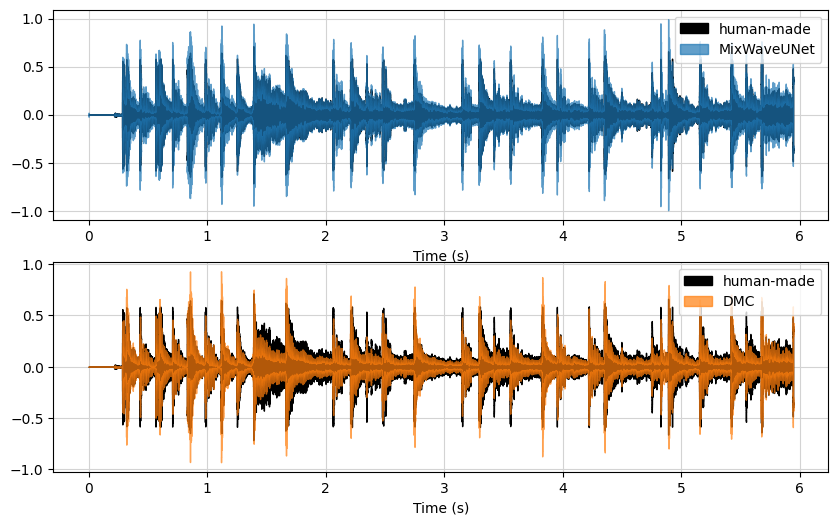

In [55]:
fig, axs = plt.subplots(2, 1)

target_audio, sr = torchaudio.load(mix_target_path)
target_audio = target_audio[:, start_sample: end_sample]

librosa.display.waveshow(
    target_audio[0,:].numpy(), 
    x_axis='s', 
    sr=SR, 
    zorder=3, 
    label='human-made', 
    color='k', 
    ax=axs[0])

wun_audio, sr = torchaudio.load(mix_auto_path_wun)
wun_audio = wun_audio[:, start_sample: end_sample]
librosa.display.waveshow(
    wun_audio[0,:].view(-1).numpy(), 
    x_axis='s', 
    sr=SR, 
    zorder=3, 
    label='MixWaveUNet', 
    color='tab:blue', 
    ax=axs[0], alpha=0.7)
axs[0].grid(c="lightgray")
axs[0].legend()

librosa.display.waveshow(
    target_audio[0,:].numpy(), 
    x_axis='s', 
    sr=SR, 
    zorder=3, 
    label='human-made', 
    color='k', 
    ax=axs[1])

dmc_audio, sr = torchaudio.load(mix_auto_path_dmc)
dmc_audio = dmc_audio[:, start_sample: end_sample]
librosa.display.waveshow(
    dmc_audio[0,:].view(-1).numpy(),
    x_axis='s',
    sr=SR,
    zorder=3,
    label='DMC', 
    color='tab:orange', 
    ax=axs[1], 
    alpha=0.7)
axs[1].grid(c="lightgray")
axs[1].legend()

## Compute the loudness, spectral, panning and dynamic features

In [56]:
target_audio = target_audio.numpy()
wun_audio = wun_audio.numpy()
dmc_audio = dmc_audio.numpy()

wun_features = get_features(target_audio, wun_audio)
dmc_features = get_features(target_audio, dmc_audio)

In [60]:
print('Mix Wave-U-Net - mean absolute percentage error per feature: ')
for k, i in wun_features.items():
    print(k, i)   

Mix Wave-U-Net - mean absolute percentage error per feature: 
lufs_loudness 0.10304796666518391
peak_loudness 0.6153269284229012
mean_mape_loudness 0.3591874475440425
centroid 0.07771542098260739
bandwidth 0.020744495126549647
contrast_lows 0.0340242359286932
contrast_mids 0.021213729148314188
contrast_highs 0.02041853119483016
rolloff 0.056812596999243334
flatness 0.21573974
mean_mape_spectral 0.06380982161452325
panning_rms_total 0.05961496488764906
panning_rms_lows 0.11983732774872062
panning_rms_mids 0.07513031193719656
panning_rms_highs 0.05747530211061939
mean_mape_panning 0.07801447667104641
rms_level 0.03705513649501611
dynamic_spread 0.034629691645848185
crest_factor 0.05918500240959792
mean_mape_dynamic 0.043623276850154075


In [61]:
print('Mix DMC - mean absolute percentage error per feature: ')
for k, i in dmc_features.items():
    print(k, i)

Mix DMC - mean absolute percentage error per feature: 
lufs_loudness 0.05079889059714656
peak_loudness 0.31816528839756636
mean_mape_loudness 0.18448208949735645
centroid 0.161513781158598
bandwidth 0.036970594586089305
contrast_lows 0.053444355894744104
contrast_mids 0.014752918499415076
contrast_highs 0.048785639733815944
rolloff 0.11574088885944224
flatness 0.33274597
mean_mape_spectral 0.10913630686108663
panning_rms_total 0.1224304003436639
panning_rms_lows 0.040148390584644006
panning_rms_mids 0.031674091920027014
panning_rms_highs 0.135606203763861
mean_mape_panning 0.08246477165304898
rms_level 0.19143726340696104
dynamic_spread 0.0821980356735922
crest_factor 0.25427215580612117
mean_mape_dynamic 0.17596915162889148


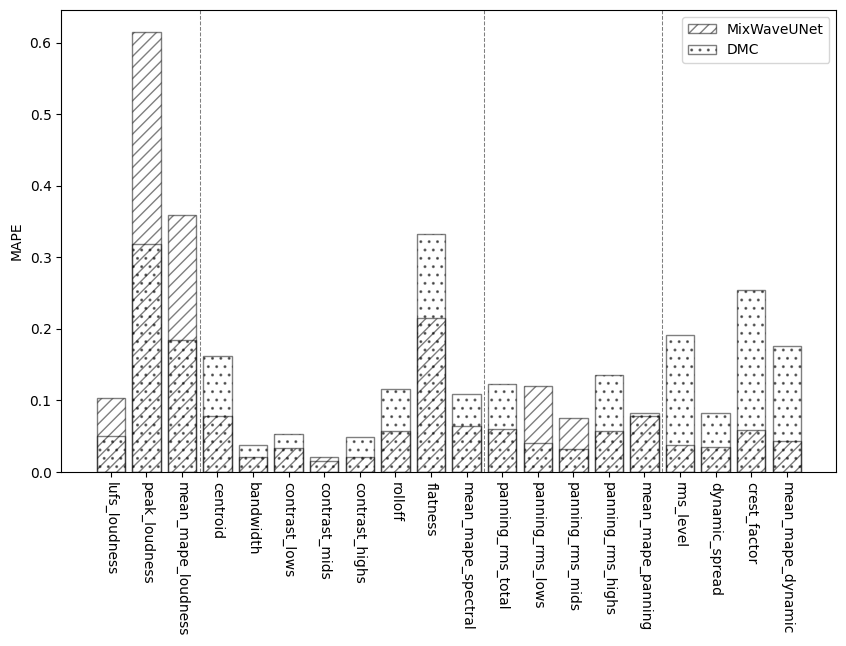

In [65]:
plt.bar(*zip(*wun_features.items()), alpha=0.5, fill=False, hatch='///', label='MixWaveUNet')
plt.bar(*zip(*dmc_features.items()), alpha=0.5,fill=False, hatch='..', label='DMC')
plt.axvline(2.5, 0, 1, linestyle='--', alpha=0.5, color='k', linewidth=0.75)
plt.axvline(10.5, 0, 1, linestyle='--', alpha=0.5, color='k', linewidth=0.75)
plt.axvline(15.5, 0, 1, linestyle='--', alpha=0.5, color='k', linewidth=0.75)
plt.xticks(rotation=-90)
plt.ylabel('MAPE')
plt.legend()
plt.show()